# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [6]:
# Import essential libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
#pip install --upgrade pip

Load the dataset.

In [4]:
pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Load and unzip the dataset


#data_path = '/content/drive/MyDrive/Data_Garbadge/Garbage_Data'
#os.listdir(data_path)
zippath = "data.zip"
extract_path = "Dataset_Waste_Segregation/"





with zipfile.ZipFile(zippath, 'r') as zip_ref:
        if(os.path.exists(os.path.join(extract_path, "data"))):
            print(f"Directory {extract_path} already exists. Please remove it before extracting.")
            exit(1)


Directory Dataset_Waste_Segregation/ already exists. Please remove it before extracting.


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [9]:
# Create a function to load the raw images

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img = Image.open(img_path)
                    img = img.resize((128, 128))  # Resize image to 128x128
                    images.append(np.array(img))
                    labels.append(label)
    return np.array(images), np.array(labels)



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [12]:
# Get the images and their labels
data_path = os.path.join(extract_path, 'data')
images, labels = load_images_from_folder(data_path)
print(f"Loaded {len(images)} images with labels.")
len(images), len(labels)

Loaded 7625 images with labels.


(7625, 7625)

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

Categories: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']


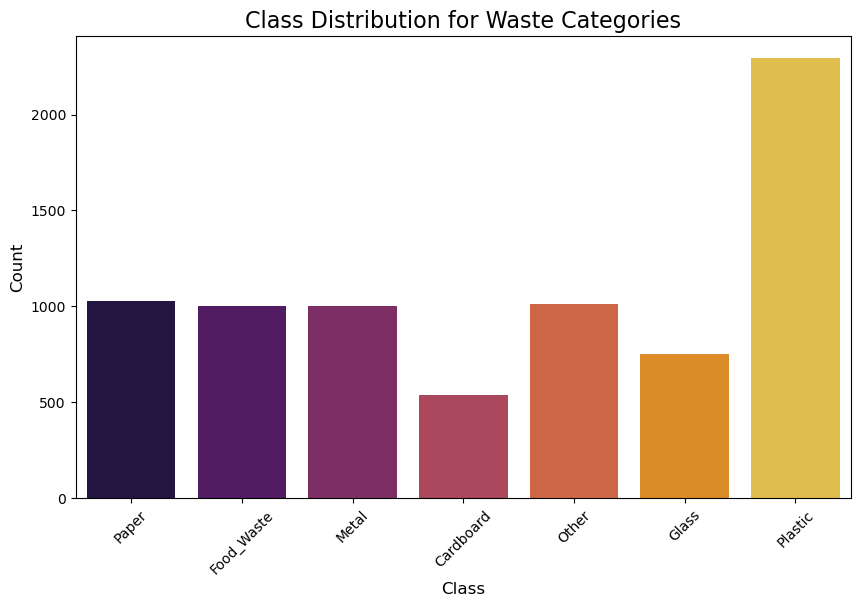

In [17]:
# Visualise Data Distribution

categories = np.unique(labels)
print(f"Categories: {categories}")

# Count the labels
label_counts = Counter(labels)

# Visualise Data Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="inferno")
plt.title("Class Distribution for Waste Categories", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [18]:
for i, category in enumerate(categories):
    print(f"Category: {category}, Number of images: {np.sum(labels == category)}")

Category: Cardboard, Number of images: 540
Category: Food_Waste, Number of images: 1000
Category: Glass, Number of images: 750
Category: Metal, Number of images: 1000
Category: Other, Number of images: 1010
Category: Paper, Number of images: 1030
Category: Plastic, Number of images: 2295


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

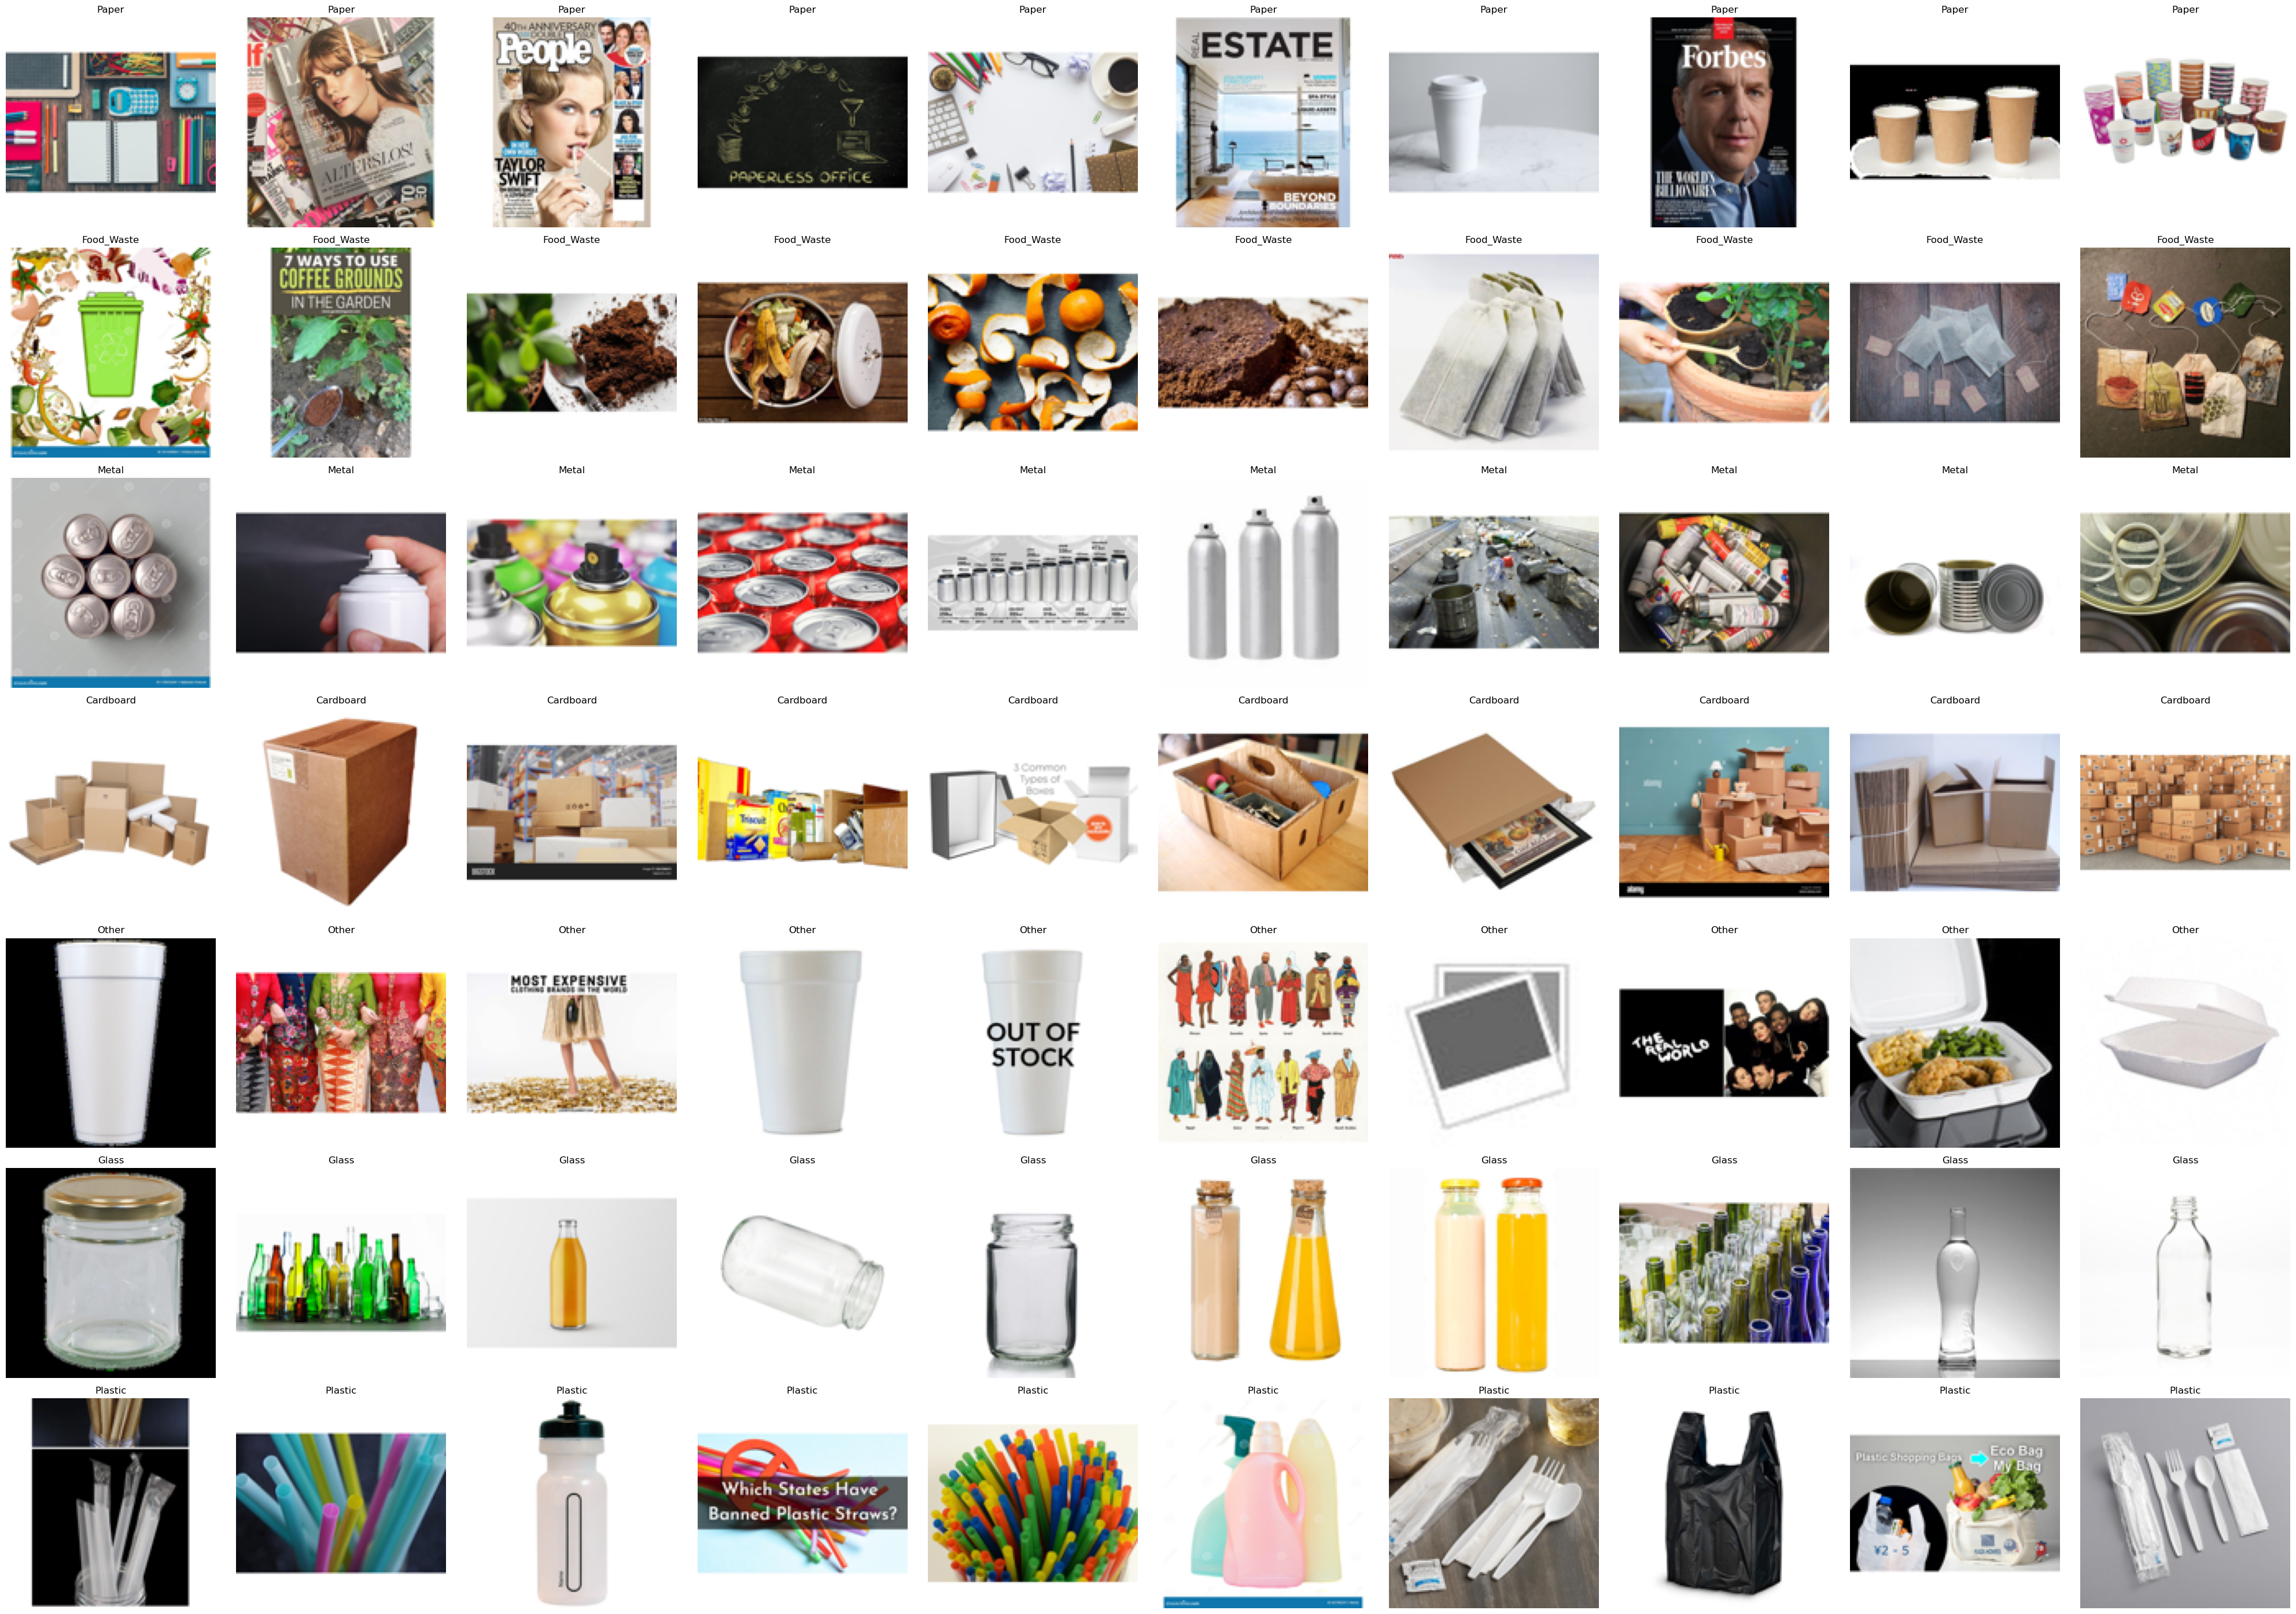

In [19]:
# Visualise Sample Images (across different labels)
num_images_to_display = 10
images_dict = {}
for category_folder in os.listdir(data_path):
    category_path = os.path.join(data_path, category_folder)
    if os.path.isdir(category_path):
        images_dict[category_folder] = []
        for filename in os.listdir(category_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(category_path, filename)
                img = Image.open(img_path)
                img = img.resize((128, 128))  # Resize image to 128x128
                images_dict[category_folder].append(np.array(img))
                if len(images_dict[category_folder]) >= num_images_to_display:
                    break
                    
plt.figure(figsize=(num_images_to_display * 4, len(images_dict) * 4))
for i, (label, imgs) in enumerate(images_dict.items()):
    for j, img in enumerate(imgs):
        plt.subplot(len(images_dict), num_images_to_display, i * num_images_to_display + j + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
plt.tight_layout()
plt.show()
                    



#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [20]:
# Find the smallest and largest image dimensions from the data set

def find_image_dimensions(data_path):
    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0

    for category_folder in os.listdir(data_path):
        category_path = os.path.join(data_path, category_folder)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img_path = os.path.join(category_path, filename)
                    with Image.open(img_path) as img:
                        width, height = img.size
                        min_width, min_height = min(min_width, width), min(min_height, height)
                        max_width, max_height = max(max_width, width), max(max_height, height)

    return (min_width, min_height), (max_width, max_height)

In [21]:
min_dimensions, max_dimensions = find_image_dimensions(data_path)
print(f"Smallest dimensions: {min_dimensions}")
print(f"Largest dimensions: {max_dimensions}")

Smallest dimensions: (256, 256)
Largest dimensions: (256, 256)


In [22]:
# Resize the image dimensions
def resize_images(data_path, output_path, target_size=(128, 128)):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    for category_folder in os.listdir(data_path):
        category_path = os.path.join(data_path, category_folder)
        output_category_path = os.path.join(output_path, category_folder)
        
        if os.path.isdir(category_path):
            if not os.path.exists(output_category_path):
                os.makedirs(output_category_path)
            
            for filename in os.listdir(category_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):
                    img_path = os.path.join(category_path, filename)
                    output_img_path = os.path.join(output_category_path, filename)
                    
                    with Image.open(img_path) as img:
                        img_resized = img.resize(target_size)
                        img_resized.save(output_img_path)
    
    print(f"Images resized and saved to {output_path}")


In [23]:
output_path = os.path.join(extract_path, 'resized_data')
resize_images(data_path, output_path, target_size=(128, 128))

Images resized and saved to Dataset_Waste_Segregation/resized_data


In [24]:
images, labels = load_images_from_folder(output_path)
print(f"Loaded {len(images)} images with labels.")

Loaded 7625 images with labels.


In [25]:
print(f"Resized images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Resized images shape: (7625, 128, 128, 3)
Labels shape: (7625,)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [26]:
# Encode the labels suitably
unique_labels, encoded_labels = np.unique(labels, return_inverse=True)

one_hot_labels = to_categorical(encoded_labels)

print("Unique Labels:", unique_labels)
print("Encoded Labels:", encoded_labels)
print("One-Hot Encoded Labels:\n", one_hot_labels)



Unique Labels: ['Cardboard' 'Food_Waste' 'Glass' 'Metal' 'Other' 'Paper' 'Plastic']
Encoded Labels: [5 5 5 ... 6 6 6]
One-Hot Encoded Labels:
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [27]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_val, y_train, y_val = train_test_split(images, one_hot_labels, test_size=0.2, stratify=labels, random_state=42)


# Print the shapes of the training and validation sets
print(f"Training set shape: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Validation set shape: X_val shape = {X_val.shape}, y_val shape = {y_val.shape}")


Training set shape: X_train shape = (6100, 128, 128, 3), y_train shape = (6100, 7)
Validation set shape: X_val shape = (1525, 128, 128, 3), y_val shape = (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [29]:
# Build and compile the model

input_shape = X_train.shape[1:]  # Shape of the input images (128, 128, 3)
num_classes = y_train.shape[1]  # Number of classes (one-hot encoded labels)

# Define the model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
# Pooling Layer 1
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
# Pooling Layer 2
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
# Pooling Layer 3
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())
# Fully Connected Layer 1
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
# Dropout Layer 1
model.add(Dropout(0.5))
# Fully Connected Layer 2
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
# Dropout Layer 2
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_6 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                      

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [ ]:
# Training

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train / 255.0,  # Normalize the images to [0, 1]
    y_train, 
    validation_data=(X_val / 255.0, y_val), 
    epochs=20, 
    batch_size=32, 
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/20
191/191 [==============================] - ETA: 0s - loss: 2.2171 - accuracy: 0.3179
Epoch 1: val_loss improved from inf to 2.43212, saving model to best_model.h5


/Users/jaws/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 161s 816ms/step - loss: 2.2171 - accuracy: 0.3179 - val_loss: 2.4321 - val_accuracy: 0.3010 - lr: 0.0010
Epoch 2/20
191/191 [==============================] - ETA: 0s - loss: 1.7026 - accuracy: 0.4089
Epoch 2: val_loss improved from 2.43212 to 1.75406, saving model to best_model.h5
191/191 [==============================] - 143s 747ms/step - loss: 1.7026 - accuracy: 0.4089 - val_loss: 1.7541 - val_accuracy: 0.3095 - lr: 0.0010
Epoch 3/20
191/191 [==============================] - ETA: 0s - loss: 1.4992 - accuracy: 0.4610
Epoch 3: val_loss improved from 1.75406 to 1.70078, saving model to best_model.h5
191/191 [==============================] - 140s 731ms/step - loss: 1.4992 - accuracy: 0.4610 - val_loss: 1.7008 - val_accuracy: 0.3705 - lr: 0.0010
Epoch 4/20
191/191 [==============================] - ETA: 0s - loss: 1.3641 - accuracy: 0.5084
Epoch 4: val_loss improved from 1.70078 to 1.53635, saving model to best_model.h5
191/191 [=============

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics

# Normalize X_val for evaluation
X_val_normalized = X_val / 255.0

# Evaluate the model on the validation set
y_pred = model.predict(X_val_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification Report for validation set
print("Classification Report for Validation Set:")
print(classification_report(y_true_classes, y_pred_classes, target_names=unique_labels))

# Confusion Matrix for validation set
cm = confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Validation Set")
plt.tight_layout()
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

In [ ]:
# Calculate accuracy
accu_score = accuracy_score(y_true_classes, y_pred_classes)
# Calculate precision, recall, and F1 score
precision_score = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall_score = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1_score = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accu_score:.4f}")
print(f"Precision: {precision_score:.4f}")
print(f"Recall: {recall_score:.4f}")
print(f"F1 Score: {f1_score:.4f}")
